In [1]:
import functools

from agents.data_cleaning_agent import DataCleaningAgent
from agents.human_agent import HumanAgent
from agents.labeling_agent import LabelingAgent
from agents.tweet_collector_agent import TweetCollectorAgent
from agents.generator_tweet_agent import GeneratorTweetAgent
from agents.test_model_agent import TestModelAgent
from agents.classifier_agent import ClassifierAgent
from agents.dataset_preparator_agent import DatasetPreparatorAgent

from langgraph.graph import StateGraph, START
from agents.supervisor_agent import SupervisorAgent
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict

[nltk_data] Downloading package wordnet to /Users/MyMac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/MyMac/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2024-11-29 23:32:18.187202: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package wordnet to /Users/MyMac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/MyMac/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
class AgentState(TypedDict):
    messages: list[HumanMessage]
    next: str
    current_index: int
    data: dict
    context: str

In [3]:
members = ["Human", "TweetCollector", "DataCleaner", "Labeler", "Generator", "Classifier", "TestModel"]
# members = ["Human", "TweetCollector", "DataCleaner", "Labeler", "Generator", "DatasetPreparator" "Classifier", "TestModel"]

In [4]:
tweet_collector = TweetCollectorAgent()
data_cleaner = DataCleaningAgent()
labeler = LabelingAgent()
human_agent = HumanAgent()
generator = GeneratorTweetAgent()
testModel = TestModelAgent()
classifier = ClassifierAgent()
# dataset_preparator = DatasetPreparatorAgent()
supervisor = SupervisorAgent(members)

In [5]:
human_node = functools.partial(SupervisorAgent.agent_node, agent=human_agent, name="Human")
tweet_collector_node = functools.partial(SupervisorAgent.agent_node, agent=tweet_collector, name="TweetCollector")
data_cleaner_node = functools.partial(SupervisorAgent.agent_node, agent=data_cleaner, name="DataCleaner")
labeler_node = functools.partial(SupervisorAgent.agent_node, agent=labeler, name="Labeler")
generator_node = functools.partial(SupervisorAgent.agent_node, agent=generator, name="Generator")
# dataset_preparator_node = functools.partial(SupervisorAgent.agent_node, agent=dataset_preparator, name="DatasetPreparator")
classifier_node = functools.partial(SupervisorAgent.agent_node, agent=classifier, name="Classifier")
test_model_node = functools.partial(SupervisorAgent.agent_node, agent=testModel, name="TestModel")

In [6]:
workflow = StateGraph(AgentState)
workflow.add_node("Human", human_node)
workflow.add_node("TweetCollector", tweet_collector_node)
workflow.add_node("DataCleaner", data_cleaner_node)
workflow.add_node("Labeler", labeler_node)
workflow.add_node("Generator", generator_node)
# workflow.add_node("DatasetPreparator", dataset_preparator_node)
workflow.add_node("Classifier", classifier_node)
workflow.add_node("TestModel", test_model_node)
workflow.add_node("supervisor", supervisor.supervisor_agent)

In [7]:
# Ajout des arêtes entre agents et le superviseur
for member in members:
    workflow.add_edge(member, "supervisor")

# Ajouter des arêtes conditionnelles à partir du superviseur
workflow.add_conditional_edges("supervisor", SupervisorAgent.supervisor_decision, supervisor.conditional_map())

# Ajouter le point d'entrée dans le workflow (HumanAgent)
workflow.add_edge(START, "Human")

# Compiler le workflow pour l'exécution
graph = workflow.compile()

--------------------
{'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={})], 'data': '', 'context': 'Gouvernement Michel Barnier'}
--------------------
{'Human': {'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={}, name='Human')], 'data': '', 'context': 'Gouvernement Michel Barnier'}}
----
Le superviseur a choisi : TweetCollector
{'supervisor': {'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={}, name='Human'), HumanMessage(content='Superviseur: Prochaine action - TweetCollector', additional_kwargs={}, response_metadata={})], 'next': 'TweetCollector', 'current_index': 1, 'data': '', 'context': 'Gouvernement Michel Barnier'}}
----
Error in invoking agent: This event loop is already running
--------------------
{'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={}, name=

/Users/MyMac/Documents/univReims/M2/systemeMultiAgents/sentimentAnalysis/agents/labeling_agent.py:23: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = self.llm(prompt)


Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
Query: Gouvernement Michel Barnier
--------------------
{'messages': [HumanMessage(content="Action effectuée par l'agent DataCleaningAgent", additional_kwargs={}, response_metadata={}, name='DataCleaner'), HumanMessage(content='Superviseur: Prochaine action - Labeler', additional_kwargs={}, response_metadata={}), HumanMessage(content="Action effectuée par l'agent LabelingAgent", additional_kwargs={}, response_metadata={})], 'data': 'data/tweets_labeled.csv', 'context': 'Gouvernement Michel Barnier'}
--------------------
{'Labeler': {'messages': [HumanMessage(content="Action

/Users/MyMac/Documents/univReims/M2/systemeMultiAgents/sentimentAnalysis/agents/classifier_agent.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({
/Users/MyMac/Documents/univReims/M2/systemeMultiAgents/sentimentAnalysis/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 500, 100)  │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 500, 100)  │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 500, 64)   │     19,264 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 500, 64)   │     19,264 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 500, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 500, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 500, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 500, 64)   │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 500, 64)   │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ dropout_1[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        387 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,055,939 (7.84 MB)

 Trainable params: 2,055,683 (7.84 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - accuracy: 0.4231 - loss: 2.2755 - precision: 0.4167 - recall: 0.3875 - val_accuracy: 0.5000 - val_loss: 1.0947 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4824 - loss: 1.5289 - precision: 0.4947 - recall: 0.4824 - val_accuracy: 0.5000 - val_loss: 1.0900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5199 - loss: 1.1873 - precision: 0.5466 - recall: 0.5051 - val_accuracy: 0.3333 - val_loss: 1.0989 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6875 - loss: 0.7651 - precision: 0.7490 - recall: 0.6875 - val_accuracy: 0.3333 - val_loss: 1.1017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5912 - loss: 0.8336 - precision: 0.5898 - recall: 0.5556 - val_accuracy: 0.

Modèle sauvegardé dans 'tweet_classifier.h5'.
--------------------
{'messages': [HumanMessage(content="Action effectuée par l'agent GeneratorTweetAgent", additional_kwargs={}, response_metadata={}, name='Generator'), HumanMessage(content='Superviseur: Prochaine action - Classifier', additional_kwargs={}, response_metadata={}), HumanMessage(content="Action effectuée par l'agent ClassifierAgent. Le modèle ANN est prêt et sauvegardé.", additional_kwargs={}, response_metadata={})], 'data': '', 'context': {'model_path': 'data/tweet_classifier.h5', 'tokenizer_path': 'data/tokenizer.pkl'}}
--------------------
{'Classifier': {'messages': [HumanMessage(content="Action effectuée par l'agent ClassifierAgent. Le modèle ANN est prêt et sauvegardé.", additional_kwargs={}, response_metadata={}, name='Classifier')], 'data': '', 'context': {'model_path': 'data/tweet_classifier.h5', 'tokenizer_path': 'data/tokenizer.pkl'}}}
----
Le superviseur a choisi : TestModel
{'supervisor': {'messages': [HumanMess

/Users/MyMac/Documents/univReims/M2/systemeMultiAgents/sentimentAnalysis/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(1, 500))',)
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


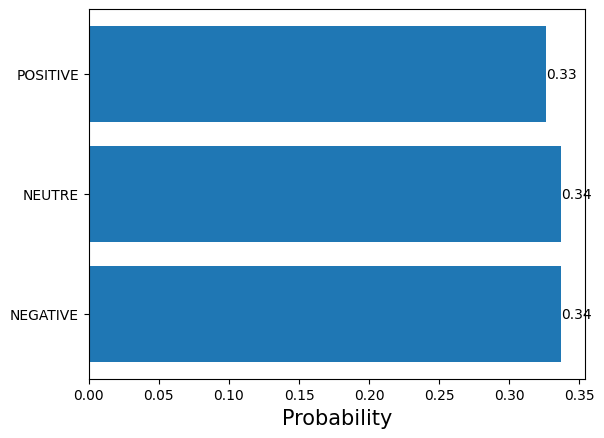

Le sentiment du tweet est: POSITIVE


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


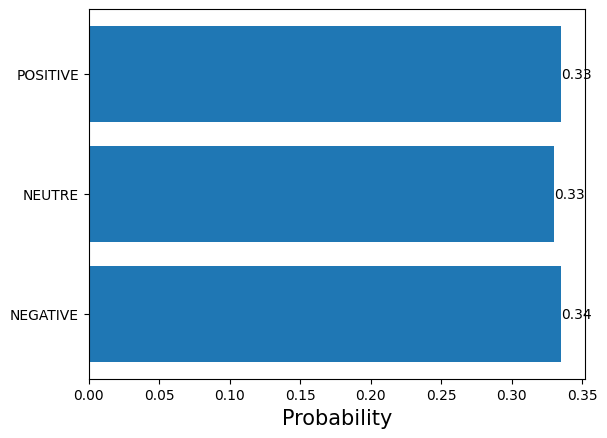

Le sentiment du tweet est: NEUTRE


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


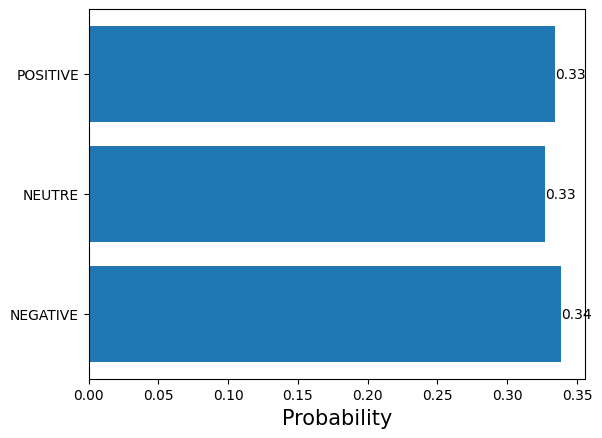

Le sentiment du tweet est: NEUTRE


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


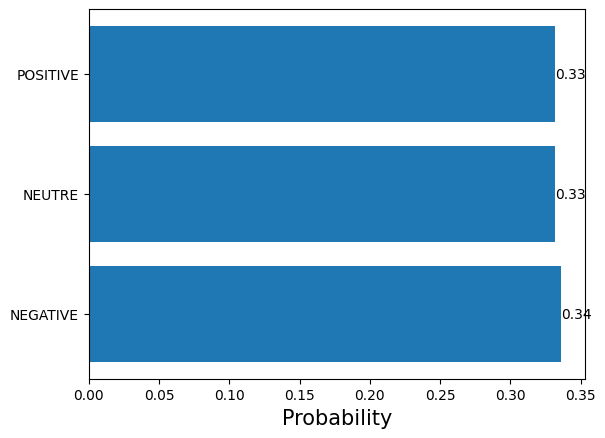

Le sentiment du tweet est: NEUTRE
--------------------
{'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={})], 'data': '', 'context': ''}
--------------------
{'TestModel': {'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={}, name='TestModel')], 'data': '', 'context': ''}}
----
Le superviseur a choisi : FINISH
{'supervisor': {'messages': [HumanMessage(content='Context provided by human:', additional_kwargs={}, response_metadata={}, name='TestModel'), HumanMessage(content='Superviseur: Prochaine action - FINISH', additional_kwargs={}, response_metadata={})], 'next': 'FINISH', 'current_index': 0, 'data': '', 'context': ''}}
----


2024-11-29 23:38:54.602 | WARNING  | twscrape.accounts_pool:add_account:88 - Account abdjibrildiallo already exists


Accounts setup successfully
Successfully fetched 16 tweets


In [ ]:
# Définition de la structure de l'état initial du workflow
initial_context_message = HumanMessage(
    content="Provide context for the tweets you want to collect. "
            "For example: 'Collect tweets related to Kamala Harris.'"
)

# Définir l'état initial avec le message de contexte
initial_state = {
    "messages": [
        initial_context_message
    ],
    "data": {},
}

# Définir une limite de récursion pour éviter des boucles infinies dans le workflow
execution_config = {"recursion_limit": 150}

# Démarrer le flux d'exécution en utilisant la méthode `stream` du graphe
events = graph.stream(
    initial_state,
    execution_config,
)

# Parcourir les événements générés par le flux et les afficher
for event in events:
    print(event)
    print("----")


In [9]:
import pandas as pd
df = pd.read_csv("tweets_labeled.csv")
df

,tweet,sentiment
0,michel barnier et ses ministres sont confronté...,NEGATIVE
1,"michel barnier et son gouvernement, dans un ef...",NEGATIVE
2,michel barnier affaibli\nil est issue dune mi...,NEGATIVE
3,plusieurs ministres et élus qui soutiennent le...,NEGATIVE
4,cest facile de dénoncer avec un petit mot dhu...,NEGATIVE
...,...,...
106,"vous me voyez dire super, on va supprimer 4 0...",NEGATIVE
107,michel barnier comme on peut le voir en espag...,NEGATIVE
108,35 du gouvernement michel barnier sont iss...,NEGATIVE
109,"vidéo vu létat du pays, on a besoin dun premi...",NEGATIVE


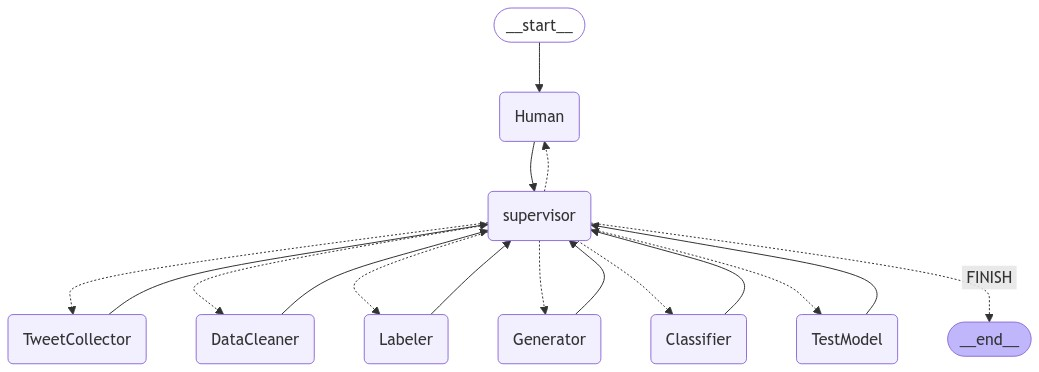

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    print("Erreur sur l'affichage")